### Import relevant libraries

In [1]:
import pathlib
import os
import datetime
import json
import sys

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
# %load_ext tensorboard

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv1D, concatenate
from tensorflow.keras.layers import ZeroPadding1D, Reshape, Input, Dropout, PReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import L2

from sklearn.metrics import mean_absolute_error, r2_score

In [6]:
import shap

In [7]:
import prd_pipeline

In [8]:
import mlflow
mlflow.tensorflow.autolog()

In [9]:
sys.path.append('/home/h02/hbrown/code/git/precip_rediagnosis/data_prep')
import drivers

### Load and preprocess data

In [10]:
configs_dir = pathlib.Path(os.environ['HOME']) / 'code/git' / 'precip_rediagnosis' / 'data_prep' / 'event_configs'
configs_dir.is_dir(), configs_dir

(True,
 PosixPath('/home/h02/hbrown/code/git/precip_rediagnosis/data_prep/event_configs'))

In [11]:
events = [
    '2020_storm_dennis', 
    '2020_storm_ciara',
    '2020_amber_nswws_oct',
    '2020_amber_nswws_dec',
    '2021_amber_nswws_feb',
    '2021_amber_nswws_oct',
    '2021_storm_barra',
    '2022_storm_eunice_franklin', 
    '2020_storm_ellen', 
    '2020_storm_francis'
]

In [12]:
root_data_dir = pathlib.Path('/project/informatics_lab/precip_rediagnosis')
prd_train_data = root_data_dir / 'train202208'

In [13]:
def get_file_name(event, configs_dir):
    config_path = configs_dir  / f'{event}.json'
    print('config file exists:', config_path.is_file())
    with open(config_path) as config_file:
        dataset_config = json.load(config_file)

    event_start_dt = datetime.datetime.strptime(dataset_config['event_start'], '%Y-%m-%dT%H:%MZ')
    event_end_dt = datetime.datetime.strptime(dataset_config['event_end'], '%Y-%m-%dT%H:%MZ')
    times_list = drivers.calc_dates_list(event_start_dt, event_end_dt, float(dataset_config['target_time_delta']))
    final_timestamp = max(times_list)  # Data extract isn't inclusive of final date so need second last time 

    start_datestring = f'{event_start_dt.year:04d}{event_start_dt.month:02d}{event_start_dt.day:02d}T{event_start_dt.hour:02d}{event_start_dt.minute:02d}Z'
    end_datestring = f'{event_end_dt.year:04d}{event_end_dt.month:02d}{event_end_dt.day:02d}T{event_end_dt.hour:02d}{event_end_dt.minute:02d}Z'
    final_datestring = f'{final_timestamp.year:04d}{final_timestamp.month:02d}{final_timestamp.day:02d}T{final_timestamp.hour:02d}{final_timestamp.minute:02d}Z'
    event_name = dataset_config["event_name"]
    return f'{event_name}/prd_merged_{start_datestring}_{final_datestring}.csv'

In [14]:
# target_parameter = list(new_bands.keys())
target_parameter = [
    'radar_fraction_in_band_instant_0.25', 
    'radar_fraction_in_band_instant_2.5',
    'radar_fraction_in_band_instant_7.0',
    'radar_fraction_in_band_instant_10.0']
profile_features = ['air_temperature', 'relative_humidity']#, 'cloud_volume_fraction', 'air_pressure']
single_lvl_features = []#['surface_altitude']#['thickness_of_rainfall_amount']#['air_pressure_at_sea_level'] 

In [15]:
feature_dict = {'profile': profile_features,
                'single_level': single_lvl_features,
                'target': target_parameter,
               } 

In [16]:
events_data_test = []
events_data_train= []
test_fraction = 0.2
for event in events:
    print(event)
    data_path = prd_train_data / get_file_name(event, configs_dir)
    
    tmpdat = pd.read_csv(data_path)
    tmpdat['time'] = pd.to_datetime(tmpdat['time'])
    tmpdat['forecast_reference_time'] = pd.to_datetime(tmpdat['forecast_reference_time'])

    df_train, df_test = prd_pipeline.sample_data(tmpdat, test_fraction)
    events_data_test.append(df_test)
    data_splits, data_dims_dict = prd_pipeline.preprocess_data(df_train, feature_dict, test_fraction=test_fraction/(1-test_fraction))

    events_data_train.append(data_splits)

2020_storm_dennis
config file exists: True
target has dims: 4
dropping smallest bin: radar_fraction_in_band_instant_0.25
getting profile columns
{'profile': ['air_temperature', 'relative_humidity'], 'single_level': [], 'target': ['radar_fraction_in_band_instant_0.25', 'radar_fraction_in_band_instant_2.5', 'radar_fraction_in_band_instant_7.0', 'radar_fraction_in_band_instant_10.0']}
2020_storm_ciara
config file exists: True
target has dims: 4
dropping smallest bin: radar_fraction_in_band_instant_0.25
getting profile columns
{'profile': ['air_temperature', 'relative_humidity'], 'single_level': [], 'target': ['radar_fraction_in_band_instant_0.25', 'radar_fraction_in_band_instant_2.5', 'radar_fraction_in_band_instant_7.0', 'radar_fraction_in_band_instant_10.0']}
2020_amber_nswws_oct
config file exists: True
target has dims: 4
dropping smallest bin: radar_fraction_in_band_instant_0.25
getting profile columns
{'profile': ['air_temperature', 'relative_humidity'], 'single_level': [], 'target':

In [17]:
data_test = pd.concat(events_data_test)
data_test.to_csv('prd_merged_all_events_test_dataset.csv')

In [18]:
data_splits = {
    'X_train': np.concatenate([event['X_train'] for event in events_data_train]),
    'X_val': np.concatenate([event['X_val'] for event in events_data_train]), 
    'y_train': pd.concat([event['y_train'] for event in events_data_train]),
    'y_val': pd.concat([event['y_val'] for event in events_data_train]),
}

In [19]:
data_test[data_test[feature_dict['target'][0]]!=1].shape

(176310, 225)

In [20]:
data_splits['y_val'].shape

(223254, 4)

In [21]:
data_splits['y_train'].shape

(628110, 4)

In [22]:
data_dims_dict

{'nprof_features': 2, 'nheights': 33, 'nsinglvl_features': 0, 'nbands': 4}

### Plot sample distributions

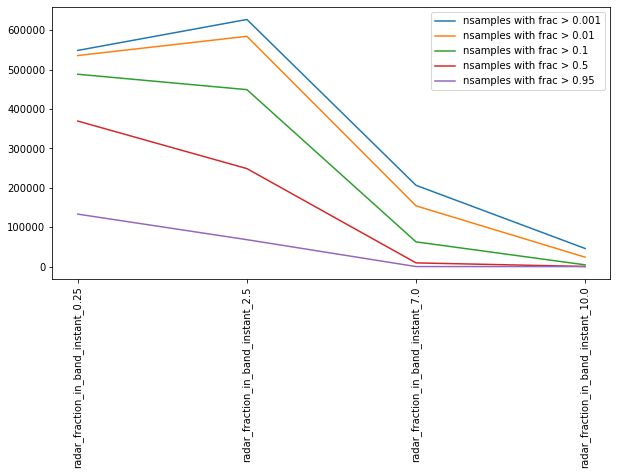

In [23]:
for frac in [0.001, 0.01, 0.1, 0.5, 0.95]:
    exceeding_prob = []
    for thresh in range(data_dims_dict['nbands']):
        exceeding_prob.append(sum(data_splits['y_train'].iloc[:, thresh] > frac))
    plt.plot(np.arange(data_dims_dict['nbands']), exceeding_prob, label=f'nsamples with frac > {frac}')
plt.xticks(np.arange(data_dims_dict['nbands']), data_splits['y_train'].columns, rotation=90)
plt.legend()
plt.gcf().set_size_inches(10, 5)
plt.show()

In [24]:
# for prob in [0.001, 0.01, 0.1, 0.5, 0.95]:
#     exceeding_prob = []
#     for thresh in range(data_dims_dict['nbands']):
#         exceeding_prob.append(sum(data_splits['y_val'].iloc[:, thresh] > prob))
#     plt.plot(np.arange(data_dims_dict['nbands']), exceeding_prob, label=f'nsamples with frac > {prob}')
# plt.xticks(np.arange(data_dims_dict['nbands']), data_splits['y_train'].columns, rotation=90)
# plt.legend()
# plt.gcf().set_size_inches(10, 5)
# plt.show()

For the train, validate and test samples, plot the distribution of number of samples in the different intensity bands that exceed a variety of threshold limits (each plot shows a different threshold limit)

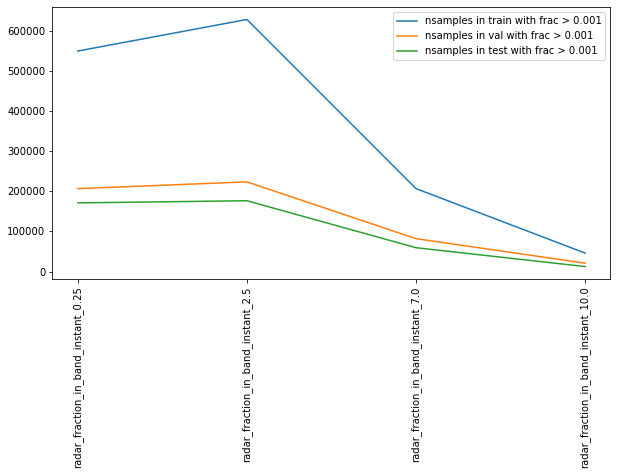

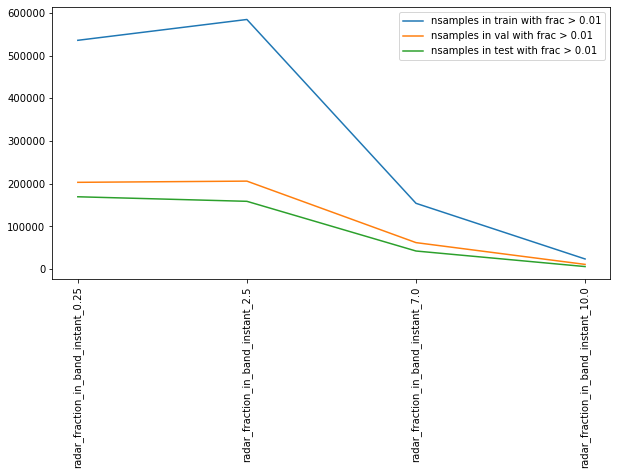

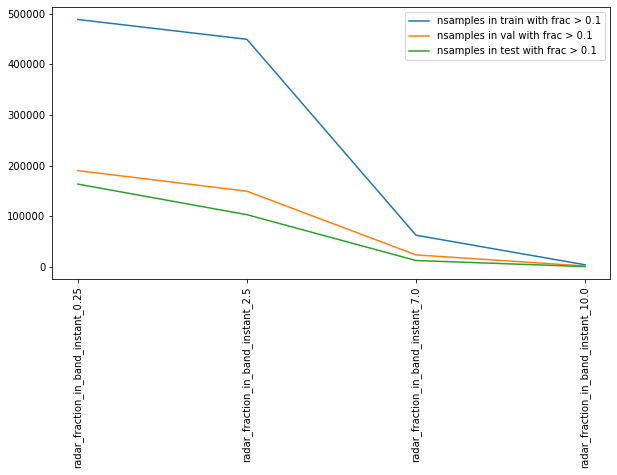

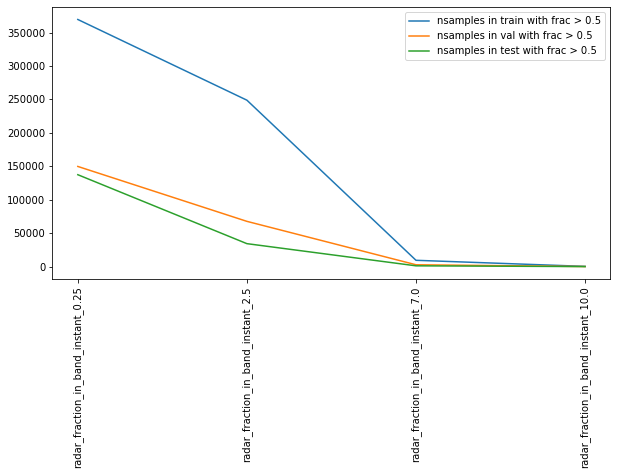

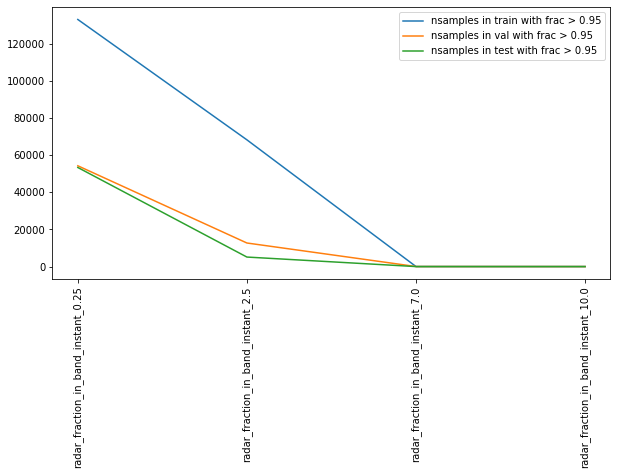

In [25]:
test_sub = data_test[data_test[feature_dict['target'][0]]!=1]  # train and validate have had this preprocessing already applied 
for prob in [0.001, 0.01, 0.1, 0.5, 0.95]:
    train, val, test = [], [], []
    for thresh in range(data_dims_dict['nbands']):
        test.append(sum(test_sub[target_parameter].iloc[:, thresh] > prob))
        val.append(sum(data_splits['y_val'].iloc[:, thresh] > prob))
        train.append(sum(data_splits['y_train'].iloc[:, thresh] > prob))
    
    plt.plot(np.arange(data_dims_dict['nbands']), train, label=f'nsamples in train with frac > {prob}')
    plt.plot(np.arange(data_dims_dict['nbands']), val, label=f'nsamples in val with frac > {prob}')
    plt.plot(np.arange(data_dims_dict['nbands']), test, label=f'nsamples in test with frac > {prob}')

    plt.xticks(np.arange(data_dims_dict['nbands']), data_splits['y_train'].columns, rotation=90)
    plt.legend()
    plt.gcf().set_size_inches(10, 5)
    plt.show()

### Resample data

Resample data to create more uniform distribution within the training data

In [26]:
# data_splits['y_train']['max_bin'] = data_splits['y_train'].idxmax(axis=1)

# nsamples = len(data_splits['y_train'])//len(data_splits['y_train'].columns)

# y_train = pd.DataFrame()

# data_splits['y_train'] = data_splits['y_train'].reset_index(drop=True)
# for col in data_splits['y_train'].columns[0:-1]:
#     ids = data_splits['y_train'][data_splits['y_train']['max_bin']==col].index
#     if len(ids)>0:
#         choices = np.random.choice(ids, nsamples)
#         y_train = pd.concat([y_train, data_splits['y_train'].loc[choices]])
#         try: 
#             X_train = np.concatenate([X_train, data_splits['X_train'][choices]])
#         except NameError:
#             X_train = data_splits['X_train'][choices]

# cols = data_splits['y_train'].columns[:-1]
# plt.plot(data_splits['y_train'].sum(axis=0)[cols], label='original data')
# plt.plot(y_train.sum(axis=0)[cols], label='resampled data')
# plt.legend()
# plt.show()

# y_train = y_train.drop(columns=['max_bin'])

# data_splits['X_train'] = X_train
# data_splits['y_train'] = y_train
# data_dims_dict['nbands'] = data_splits['y_train'].shape[1]

## Set up model and experiment

In [32]:
def build_model(nprof_features, nheights, nsinglvl_features, nfractions=23):
    
    profile_input = Input(shape=(nheights, nprof_features), name='profile_input')
    prof_size = nheights*nprof_features

    out = ZeroPadding1D(padding=1)(profile_input)
    out = Conv1D(32, 3, strides=1, activation='relu')(out) #use_bias=False, bias_initializer='zeros'
    # out = Dropout(0.25)(out)
    ident = out
    out = ZeroPadding1D(padding=1)(out)
    out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, bias_initializer='zeros')(out)
    out = ZeroPadding1D(padding=1)(out)
    out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, kernel_initializer='glorot_uniform', bias_initializer='zeros')(out)
    x = tf.keras.layers.add([out, ident])
    out = Flatten()(x)
    out = Dense(prof_size, activation='relu')(out) # use_bias=False,
    # out = Dropout(0.1)(out)

    if nsinglvl_features > 0:
        surf_input = Input(shape=(nsinglvl_features,), name='surf_input')
        flat_profs = Flatten()(profile_input)
        raw_in = tf.keras.layers.concatenate([flat_profs, surf_input])
        raw_size = (nheights*nprof_features)+nsinglvl_features

        out = tf.keras.layers.concatenate([out, surf_input])
        x = tf.keras.layers.add([out, raw_in])
        x = Dense(1024, use_bias=False, activation='relu')(x)
        x = Dense(1024, use_bias=False, activation='relu')(x)

        main_output = Dense(nfractions, use_bias=True, activation='softmax', name='main_output')(x)
        model = Model(inputs=[profile_input, surf_input], outputs=[main_output])

    else:
        main_output = Dense(nfractions, activation='softmax', name='main_output')(out) # use_bias=True, 
        model = Model(inputs=[profile_input], outputs=[main_output])
        
    return model

## Run experiment

Here we actually run the training and evaluation. All parameters and the output model will be saved through ML Flow, and we can track training stats through tensorboard.

In [37]:
def train_model(model, data_splits):
    # TODO: these hyperparameters should be read in from somewhere?
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
    # model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=optimizer)
    model.compile(loss=tf.keras.losses.KLDivergence(), optimizer=optimizer, metrics=['accuracy'],)
    # model.compile(loss='mean_absolute_error', optimizer=optimizer)

    history = model.fit(data_splits['X_train'], 
                        data_splits['y_train'], 
                        epochs=20, 
                        batch_size=100, 
                        validation_data=(data_splits['X_val'], data_splits['y_val']),  verbose=True)
    return model, history

In [38]:
# exp = mlflow.create_experiment(f'prd_{radar_type}')
# exp

In [39]:
exp1 = mlflow.get_experiment('3')
exp1

<Experiment: artifact_location='file:///net/home/h02/hbrown/code/git/precip_rediagnosis/model_pipeline/mlruns/3', experiment_id='3', lifecycle_stage='active', name='prd_radar_fraction_in_band_instant', tags={}>

In [ ]:
with mlflow.start_run(experiment_id=exp1.experiment_id, run_name='multi_event_data_time_sampling') as current_run:
    mlflow.log_param('features', feature_dict['profile'] + feature_dict['single_level'])
    model = build_model(data_dims_dict['nprof_features'], data_dims_dict['nheights'], data_dims_dict['nsinglvl_features'], data_dims_dict['nbands'])
    model.summary()
    model, history = train_model(model, data_splits)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 profile_input (InputLayer)     [(None, 33, 2)]      0           []                               
                                                                                                  
 zero_padding1d_6 (ZeroPadding1  (None, 35, 2)       0           ['profile_input[0][0]']          
 D)                                                                                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 33, 32)       224         ['zero_padding1d_6[0][0]']       
                                                                                                  
 zero_padding1d_7 (ZeroPadding1  (None, 35, 32)      0           ['conv1d_6[0][0]']         

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.


Epoch 1/20
6282/6282 [==============================] - 30s 5ms/step - loss: 0.3444 - accuracy: 0.7061 - val_loss: 0.3293 - val_accuracy: 0.7226
Epoch 2/20
2642/6282 [===========>..................] - ETA: 14s - loss: 0.3223 - accuracy: 0.7205

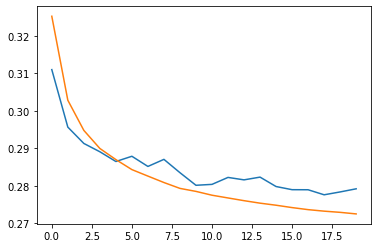

In [54]:
plt.plot(range(20), history.history['val_loss'])
plt.plot(range(20), history.history['loss'])

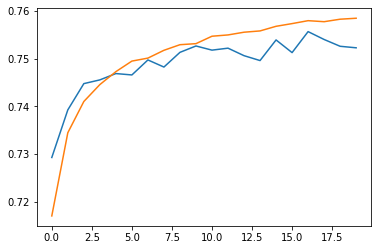

In [58]:
plt.plot(range(20), history.history['val_accuracy'])
plt.plot(range(20), history.history['accuracy'])

In [60]:
y_pred = model.predict(data_splits['X_val'])

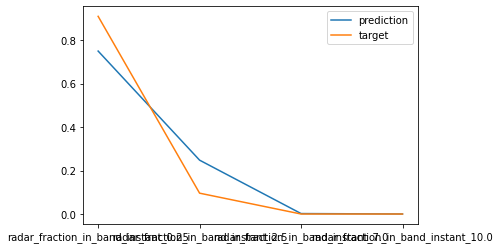

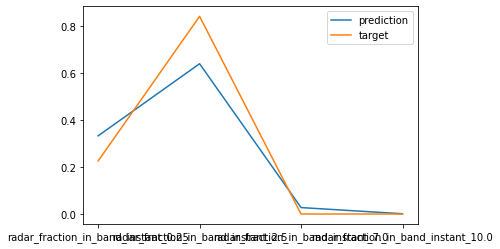

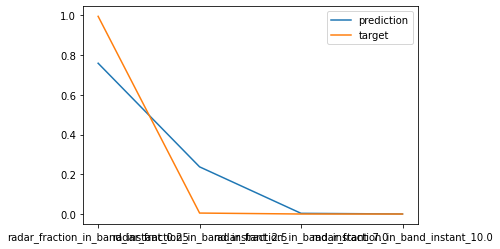

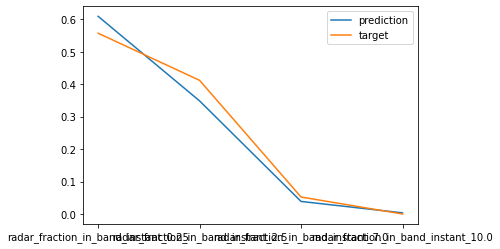

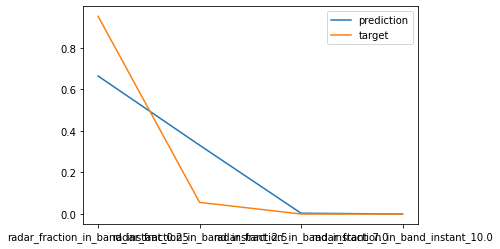

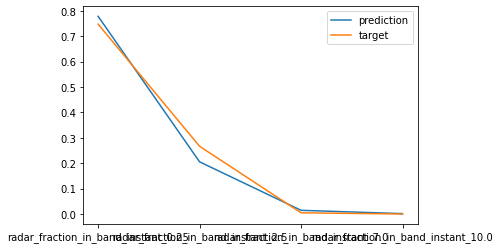

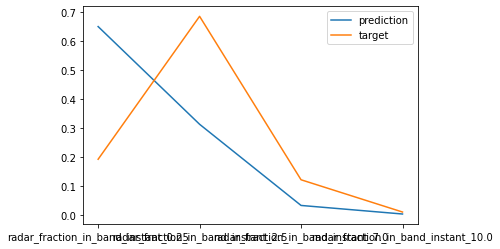

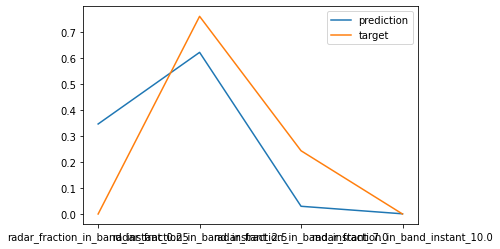

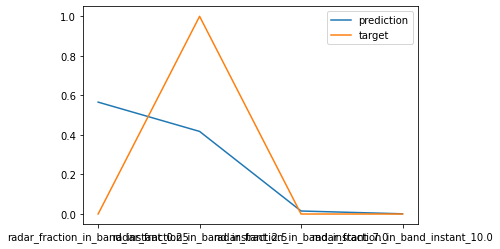

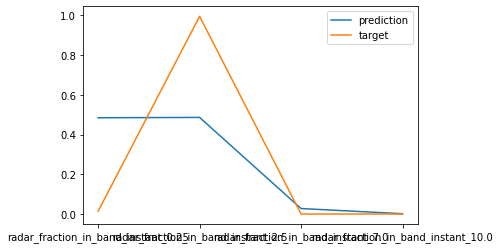

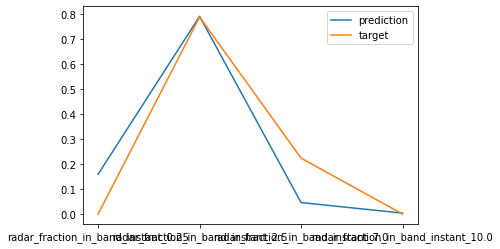

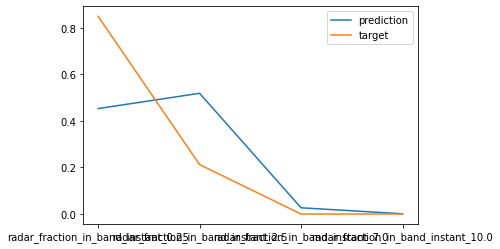

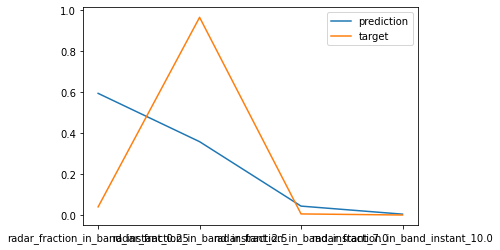

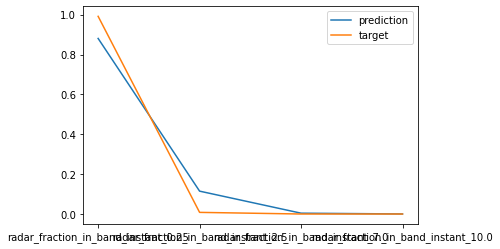

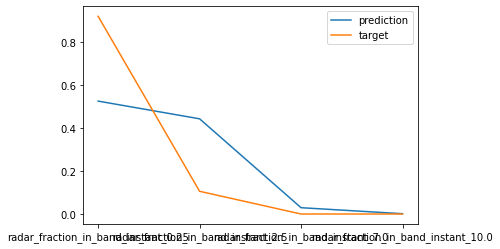

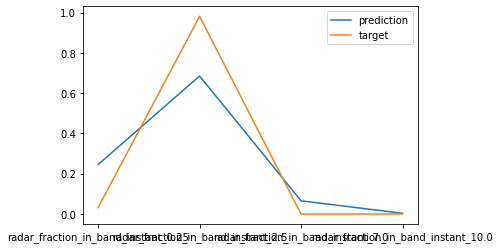

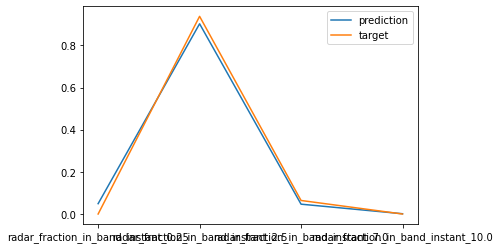

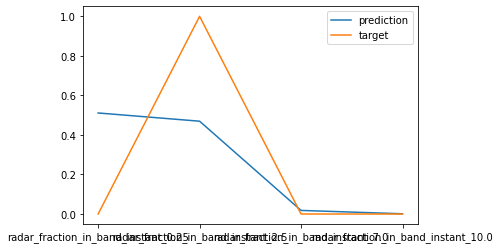

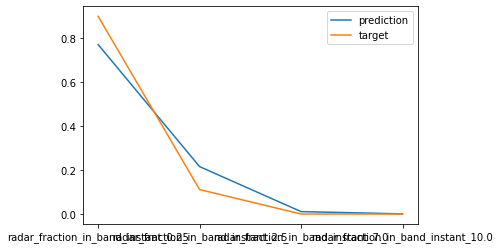

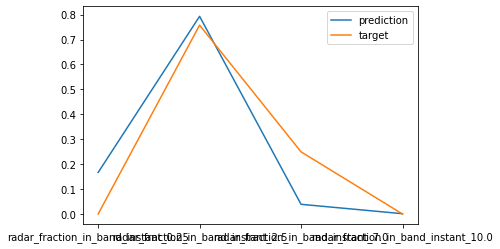

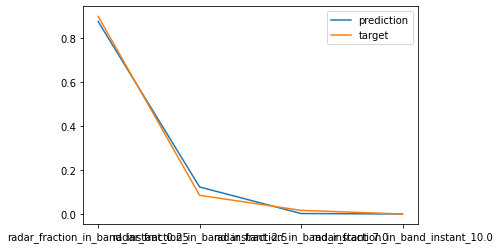

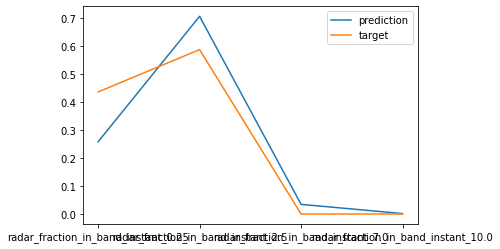

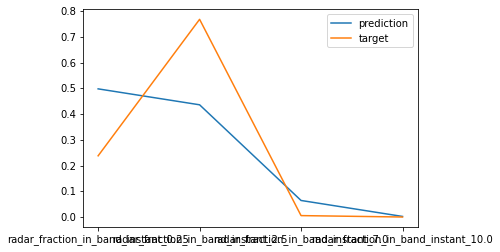

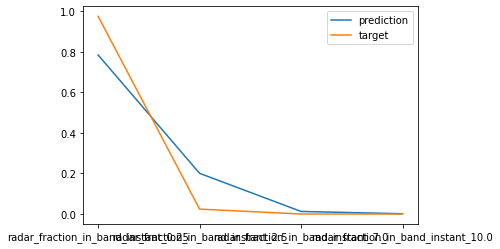

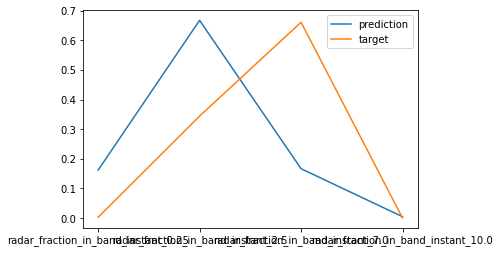

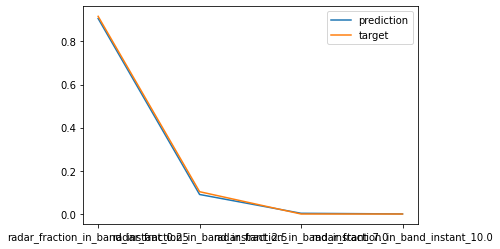

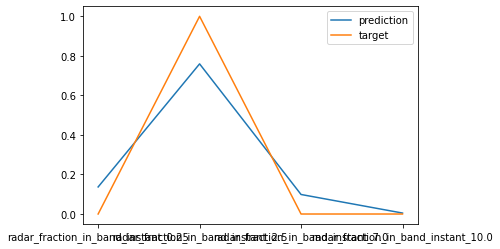

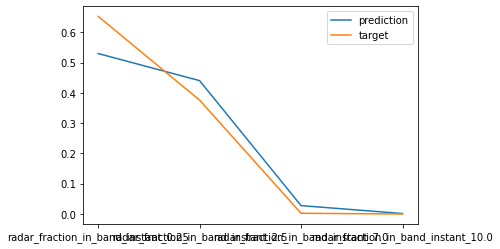

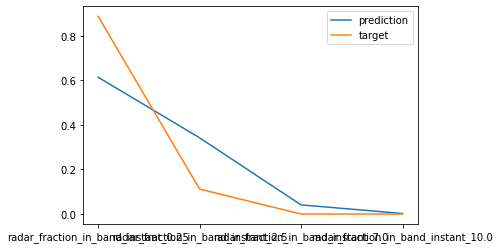

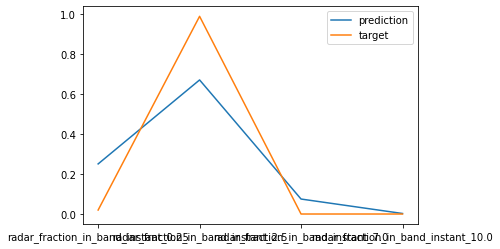

In [61]:
for loc in range(30):
    plt.plot(y_pred[loc], label='prediction')
    plt.plot(data_splits['y_val'].iloc[loc], label='target')
    plt.legend()
    plt.show()

In [ ]:
model.layers

In [ ]:
model.layers[0].input

In [ ]:
model.layers[-1].output

In [ ]:
# select a set of background examples to take an expectation over
background = data_splits['X_train'][np.random.choice(data_splits['X_train'].shape[0], 100, replace=False)]

# explain predictions of the model on three images
# e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)

shap_values = e.shap_values(data_splits['X_val'][0:1])

shap.summary_plot(shap_values[0])

In [ ]:
for prob in [0.001, 0.01, 0.1, 0.5, 0.95]:
    exceeding_prob = []
    for thresh in range(4):
        exceeding_prob.append(sum(data_splits['y_train'].iloc[:, thresh] > prob))
    plt.plot(np.arange(4), exceeding_prob, label=f'nsamples with frac > {prob}')
plt.xticks(np.arange(4), data_splits['y_train'].columns, rotation=90)
plt.legend()
plt.gcf().set_size_inches(10, 5)
plt.show()

In [ ]:
for prob in [0.000001, 0.001, 0.01, 0.1, 0.5, 0.95]:
    exceeding_prob = []
    for thresh in range(4):
        exceeding_prob.append(sum(data_splits['y_val'].iloc[:, thresh] > prob))
    plt.plot(np.arange(4), exceeding_prob, label=f'nsamples with frac > {prob}')
plt.xticks(np.arange(4), data_splits['y_train'].columns, rotation=90)
plt.legend()
plt.gcf().set_size_inches(10, 5)
plt.show()

In [ ]:
for prob in [0.000001, 0.001, 0.01, 0.1, 0.5, 0.95]:
    exceeding_prob = []
    for thresh in range(4):
        exceeding_prob.append(sum(y_pred[:, thresh] > prob))
    plt.plot(np.arange(4), exceeding_prob, label=f'nsamples with frac > {prob}')
plt.xticks(np.arange(4), data_splits['y_train'].columns, rotation=90)
plt.legend()
plt.gcf().set_size_inches(10, 5)
plt.show()

In [ ]:
data_splits['y_train'].iloc[:, thresh]

In [ ]:
for thresh in range(4): 
    bins=np.linspace(0,1,51)
    # plt.hist(y_pred[:, thresh], alpha=0.5, label='pred', bins=bins, log=True)#,stacked=True, density=True
    # plt.hist(data_splits['y_val'].iloc[:, thresh], alpha=0.5, label=f'val {thresh}', bins=bins,log=True, ) # stacked=True, density=True
    plt.hist(data_splits['y_train'].iloc[:, thresh], alpha=0.5, label=f'train {thresh}', bins=bins, log=True)#  stacked=True, density=True
    plt.legend()
    plt.show()

In [ ]:
for thresh in range(4): 
    bins=np.linspace(0,1,51)
    plt.hist(y_pred[:, thresh], alpha=0.5, label='pred', bins=bins, log=True)#,stacked=True, density=True
    plt.hist(data_splits['y_val'].iloc[:, thresh], alpha=0.5, label=f'val {thresh}', bins=bins,log=True, ) # stacked=True, density=True
    # plt.hist(data_splits['y_train'].iloc[:, thresh], alpha=0.5, label=f'train {thresh}', bins=bins, histtype='step', log=True)#  stacked=True, density=True
    plt.legend()
    plt.show()
    
#     error = mean_absolute_error(data_splits['y_val'].iloc[:, thresh], y_pred[:, thresh])
#     print(f'MAE: {error:.3f}')
#     rsqrd = r2_score(data_splits['y_val'].iloc[:, thresh], y_pred[:, thresh])
#     print(f'R-squared score: {rsqrd:.3f}')
    